# Daily Digest for Central Banks Announcements


## Why It Matters
Central bank announcements can trigger significant movements in currency, bond, and equity markets. Timely identification of emerging narratives around monetary policy, rate decisions, and economic outlooks is critical for traders, analysts, and policymakers seeking to anticipate market reactions and adjust strategies accordingly.

## What It Does
This workflow identifies, verifies, clusters, and summarizes the most relevant and impactful news related to central bank announcements. It uses the Bigdata API for content retrieval and large language models for topic analysis, producing daily market reports and structured datasets for monitoring or backtesting.

## How It Works
The notebook implements a four-step agentic workflow built on Bigdata API:

- **Lexicon Generation** of monetary policy and central bank–specific terminology to maximize recall in news retrieval.

- **Content Retrieval** via the Bigdata API, splitting searches into daily windows and parallelizing keyword lookups for speed.

- **Topic Clustering & Selection** to verify, group, and summarize news into ranked trending topics, scoring each for trendiness, novelty, impact, and magnitude.

- **Custom Report Generation** in the form of a daily digest with a configurable ranking system, supported by granular news sources for verification.

## A Real-World Use Case

This cookbook illustrates the full workflow through a practical example: tracking the most discussed  topics in central bank communications during the week of the 2025 Jackson Hole meeting. You'll learn how to transform unstructured policy-related news into structured, ranked insights on market-moving announcements.

## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [1]:
import datetime
start = datetime.datetime.now()

try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed or not available")

✅ nest_asyncio applied


## Environment Setup

The following cell configures the necessary path for the analysis

In [2]:
import os
import sys


current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Import the core libraries needed for trending topics analysis, including the lexicon generation classes and data processing tools.

In [3]:
from bigdata_client import Bigdata
from bigdata_client.models.search import DocumentType
from src.lexicon_generator import LexiconGenerator
from src.search_topics import search_by_keywords
from src.topics_extractor import (process_all_reports,
                                run_process_all_trending_topics,
                                run_add_advanced_novelty_scores,
                                add_market_impact_to_df,
                                prepare_data_for_report,
                                generate_html_report,
                                save_html_report)
from IPython.display import display
from IPython.core.display import HTML

## Load Credentials

In [4]:

from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
#load_dotenv(script_dir / '.env')
load_dotenv(os.path.abspath("/home/abouchs/.python_env_var/.env"))

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [5]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining Your Daily Digest Context and Parameters

To perform a trending topics analysis, we need to define a few key parameters:

- **Main Theme** (`main_theme`): The main topic, asset class, or context to analyze (e.g. Central Bank Announcements)

- **Time Period** (`start_date` and `end_date`): The date range over which to run the search

- **Document Type** (`document_type`): Specify which documents to search over (transcripts, filings, news)

- **Model Selection** (`llm_model`): The AI model used for semantic analysis and topic classification

In [6]:
# ===== Context Definition =====
main_theme = "Central Bank Announcements"

# ===== Specify Time Range =====
start_query = '2025-08-18'
end_query = '2025-08-25'

# ===== Query Configuration =====
document_type = DocumentType.NEWS

# ===== LLM Specification =====
llm_model = "gpt-4o-mini"

## Define Output Paths

We define the output paths for our results.

In [7]:
# Define output file paths for our report
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

export_path = f"{output_dir}/daily_digest_{main_theme.lower().replace(' ', '_')}.csv"

## Instantiating the Lexicon Generator

In this step, we identify the specialized industry-specific jargon relevant to the Central Banks Announcements to ensure a high recall in the content retrieval.

In [8]:
lexicongenerator = LexiconGenerator(openai_key=OPENAI_API_KEY, model="gpt-4o", seeds=[123, 123456, 123456789, 456789, 789])

In [9]:
keywords = lexicongenerator.generate(theme=main_theme)

## Content Retrieval from Bigdata Search API

In this section, we perform a keyword search on the news content with the Bigdata API to retrieve documents, splitting the search over daily timeframes and multi-threading the content search on the individual keywords for speed purpose. The user can define the time range below to generate daily reports between the start and end dates.

With the list of market-specific keywords parameters, you can leverage the Search functionalities in bigdata-research-tools, built with Bigdata API, to run search at scale against news documents. We need to define 2 more parameters for search:

- **Frequency** (`freq`): The frequency of the date ranges to search over. It should at least match the frequency of your daily digest. Supported values:
    - `Y`: Yearly intervals.
    - `M`: Monthly intervals.
    - `W`: Weekly intervals.
    - `D`: Daily intervals. Defaults to `D`.
- **Document Limit** (`document_limit`): The maximum number of documents to return per query to Bigdata API.

In [10]:
# ===== Query Configuration =====
document_limit = 10 # Maximum number of documents to retrieve per query
frequency = 'D'  # Query frequency

In [11]:
results, daily_keyword_count = search_by_keywords(
    keywords=keywords,
    start_date=start_query,
    end_date=end_query,
    freq=frequency,
    scope=document_type,
    document_limit=document_limit)

About to run 512 queries
Example Query: Keyword('Central Bank Announcements') over date range: AbsoluteDateRange('2025-08-18T00:00:00', '2025-08-18T23:59:59')


Querying Bigdata...: 100%|██████████| 512/512 [01:46<00:00,  4.81it/s]


## Topic Clustering and Summarization

In this step, we perform topic modelling using a large language model to verify and cluster the news. Then, the summarization ensures topic selection identifying the top trending news for Central Banks Announcements, while deriving advanced analytics to quantify the trendiness (based on news volume), novelty (based on daily changes in summaries), impact and magnitude (based on the impact on Equity prices) of the trending topics.

Before performing the topic clustering, we apply a verification layer to remove the news that are not relative to the Central Banks announcements

In [12]:
semaphore_size = 1000 # Maximum number of concurrent requests to Openai API
 
# Assuming unique_reports is your DataFrame
filtered_reports = process_all_reports(results, llm_model, OPENAI_API_KEY, main_theme, semaphore_size)

Filtering News:   0%|          | 0/7656 [00:00<?, ?it/s]

In this cell, we leverage a LLM to perform topic modeling, identifying and clustering the key topics from the news reports.

In [13]:
flattened_trending_topics_df = run_process_all_trending_topics(
    unique_reports=filtered_reports,
    model=llm_model,
    start_query=start_query,
    end_query=end_query,
    api_key=OPENAI_API_KEY,
    main_theme=main_theme,
    batches=20 #number of batches to process the reports in parallel (adjust based on your system's capabilities)
)

Extracting Topics for 2025-08-18:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting Topics for 2025-08-19:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting Topics for 2025-08-20:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting Topics for 2025-08-21:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting Topics for 2025-08-22:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting Topics for 2025-08-23:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting Topics for 2025-08-24:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting Topics for 2025-08-25:   0%|          | 0/20 [00:00<?, ?it/s]

Consolidating topics...


Consolidating topic batches: 100%|██████████| 9/9 [00:17<00:00,  1.96s/it]


Summarizing text for each topic...


Generating titles: 100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


Generating Day in Review summaries...
Adding one-line summaries to DataFrame...


Generating text summaries: 100%|██████████| 1921/1921 [00:59<00:00, 32.37it/s] 


## Topic Scoring

**Trendiness and Novelty Scores**: We derive analytics related to the trendiness of the topic based on the news volume, and the novelty of the topic based on the changes in daily summaries, evaluating the uniqueness and freshness of each topic. 

In [16]:
# Calculate trendiness and novelty scores, assessing the uniqueness and freshness of each topic
flattened_trending_topics_df = run_add_advanced_novelty_scores(flattened_trending_topics_df, api_key = os.environ['OPENAI_API_KEY'], main_theme = main_theme)

Calculating Novelty Scores:   0%|          | 0/34 [00:00<?, ?it/s]

**Price impact**: We derive analytics related to the impact (Positive, Negative) and magnitude (High, Medium, Low) of the topics, inferring their  market impact on equity prices. The prince impact inference is based on the price mechanisms and the perceived sentiment and market reaction of the news on the market.

In [17]:
# Assess the market impact for each topic, evaluating how each topic influences Equity market
point_of_view = 'Domestic Equity market'
flattened_trending_topics_df = add_market_impact_to_df(flattened_trending_topics_df, api_key = os.environ['OPENAI_API_KEY'], main_theme = main_theme, point_of_view = point_of_view)

We display the results of topic modeling and summarization. The **Topic** column represents the themes inferred through topic clustering using a LLM, which groups the news articles based on their content and underlying themes. The **Summary** provides a synthesized overview of all news articles within the same topic, offering a high-level view of the key messages for each cluster. The **Topic** is then rephrased into a concise form based on the summary. The **Text_Summary** provides a detailed summary of each individual chunk, capturing its core message.

For verification purpose, this actionable timestamped dataframe contains the granular news clustered into relevant topics, and also the advanced analytics of trendiness, novelty, impact, and magnitude scores to be potentially used for backtesting. 

In [18]:
flattened_trending_topics_df.head()

,Date,Day_in_Review,Topic,Summary,Source,Headline,Text,Volume_Score,Text_Summary,Volume_Score,Novelty_Score,Impact_Score,Magnitude_Score
0,2025-08-18,- **Inflation Pressures**: Central banks globa...,Global Central Banks Tackle Inflation and Grow...,Central Bank Interest Rate Policies are curren...,Independent Online,BER flags economic implications of changing in...,"Conversely, in a pessimistic scenario where Tr...",7,Failure to meet the 3% inflation target while ...,7,Old,Negative,High
35,2025-08-18,- **Inflation Pressures**: Central banks globa...,Global Central Banks Tackle Inflation and Grow...,Central Bank Interest Rate Policies are curren...,Business Standard via Web,Japanese markets hit a new record high,ahead of inflation data due this week that cou...,3,The Bank of Japan's potential rate hike decisi...,3,Old,Negative,High
36,2025-08-18,- **Inflation Pressures**: Central banks globa...,Global Central Banks Tackle Inflation and Grow...,Central Bank Interest Rate Policies are curren...,MT Newswires,"US Dollar Rises Early Monday; Housing Data, FO...",USD/JPY rose to 147.4151 from 147.2012 at the ...,3,The USD/JPY exchange rate increased as Japanes...,3,Old,Negative,High
37,2025-08-18,- **Inflation Pressures**: Central banks globa...,Global Central Banks Tackle Inflation and Grow...,Central Bank Interest Rate Policies are curren...,Livemint,Traders Boost Bets BOE Will Hold Rate at 4% fo...,The change in outlook for BOE policy is boosti...,3,The Bank of England's policy outlook shift is ...,3,Old,Negative,High
38,2025-08-18,- **Inflation Pressures**: Central banks globa...,Central Bank Rate Cuts Drive Market Shifts Ami...,"Market reactions to central bank policies, par...",Nairametrics,Monetary Policy Rate cuts and disinflation: Ba...,"Yet, much of this rally has been driven by str...",3,Strong earnings expectations and investor infl...,3,Old,Positive,High


In [19]:
## Export the final dataframe

flattened_trending_topics_df.to_csv(export_path, index=False)

## Generate a Custom Daily Digest

In this step, we rank the topics, allowing the user to customize the ranking system to reindex the news, based on their trendiness, novelty, and impact on equity prices. We finally display a daily market update, supported by the corresponding granular news and sources for verification purpose.

The user selects the date for the report summarizing the top trending topics, and customizes the ranking system to prioritize the topics based on volume (trendiness and media attention), novelty (based on the emergence of new daily news), impact direction (positive or negative), and magnitude. The ranking system prioritizes the criteria in the order specified by the user, allowing for a tailored focus on the most relevant aspects of the data.

The order in which the criteria are listed in user_selected_ranking determines their priority for ranking the topics within the report. The first criterion in the list has the highest priority, followed by the second, and then the third. The user can customize the ranking by choosing to prioritize impact direction (positive or negative), novelty, magnitude, or volume, and has the flexibility to select 1, 2, or all 3 criteria based on their specific needs.

In [32]:
specific_date = '2025-08-25'  # Example date, can be modified as needed
user_selected_ranking = ['novelty', 'volume', 'magnitude']  # User can modify this list to change the ranking order
#impact_filter = 'positive_impact' #User can use the impact_filter to filter out the report

In [33]:
prepared_reports = prepare_data_for_report(flattened_trending_topics_df, user_selected_ranking, impact_filter = None, report_date = specific_date)


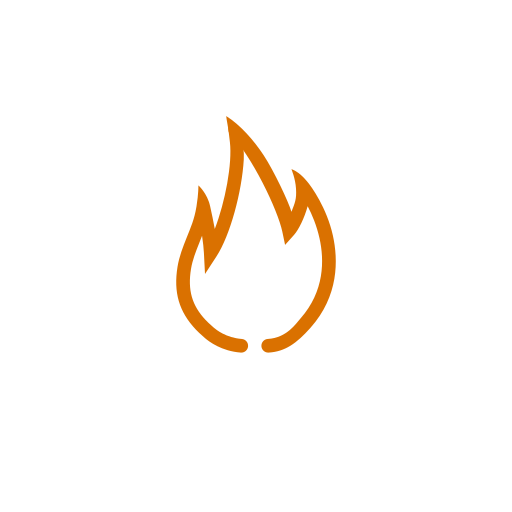
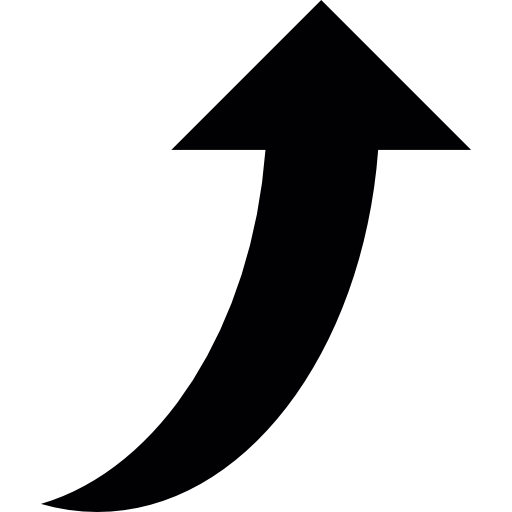
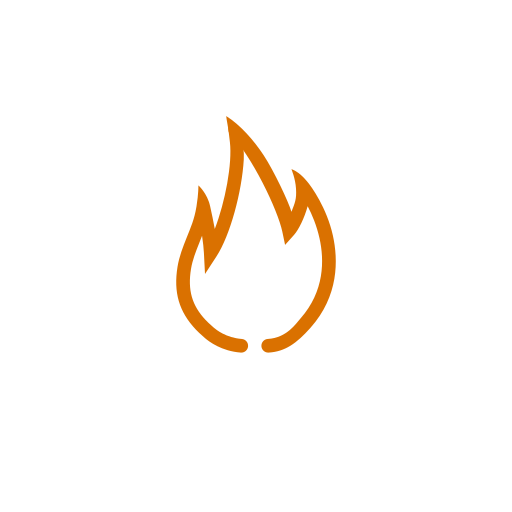
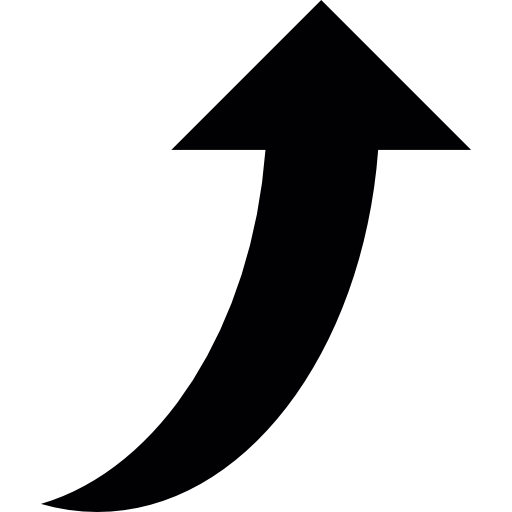
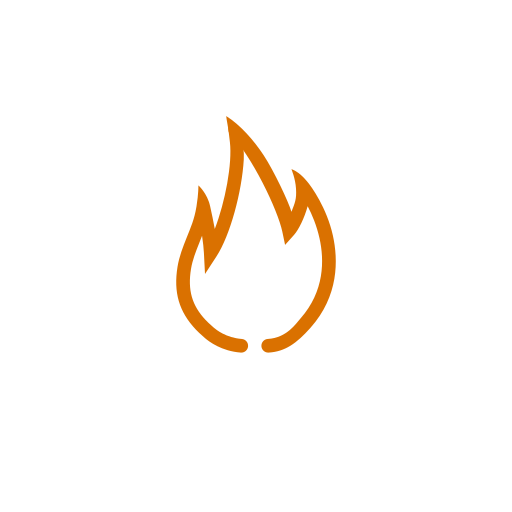
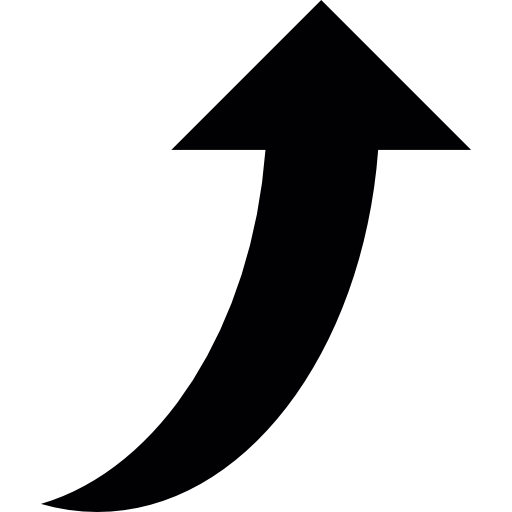

Report saved to ./output/2025-08-25_Central_Bank_Announcements.html





In [34]:
# Generate and display the HTML report for each date
for report in prepared_reports:
    html_content = generate_html_report(
        report['date'],
        report['day_in_review'],
        report['topics'],
        main_theme  # Pass the main theme to dynamically generate the title
    )
    display(HTML(html_content))
    save_html_report(html_content, report['date'], main_theme)
    print("")
    print("")
    print("")